<a href="https://colab.research.google.com/github/Henning-Kubatzsch/Tutorials/blob/main/Makemore/03_MakemoreShort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

In this notebook, we explore the internals of multi-layer perceptrons (MLPs) and investigate how the distribution of activations and gradients evolves during training. By analyzing forward pass statistics and backward gradients, we highlight common challenges in deep learning—especially those caused by poor weight initialization or improper scaling.

To better understand the health of our network, we employ diagnostic tools such as activation histograms and gradient visualizations. This helps uncover why training deep networks can be unstable, and introduces a key technique that improves training robustness: Batch Normalization.

While this notebook focuses on activations and normalization, topics like residual connections and the Adam optimizer are marked as future extensions.

# Initialize Dataset

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all words
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt -O names.txt
words = open('names.txt').read().splitlines()

--2025-06-05 12:51:44--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2025-06-05 12:51:44 (5.71 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
# build the vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


# Generate Dataset - using Splits

In [4]:
# built dataset
block_size = 3

def build_dataset(words):
  X, Y = [], []

  for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

#print(len(words[:n1]))
#print(len(words[n1:n2]))
#print(len(words[n2:]))


Xtr, Ytr = build_dataset(words[:n1])      # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])      # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Softmax and Loss — Quick Recap



### Softmax definition

$$
\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}}
$$

* Takes a vector of **logits** (raw scores from the model)
* Converts them into a **probability distribution** over classes
* Output values sum to 1 and are all positive

---

### Logits vs. Probabilities

* **Logits:**
  Raw model outputs (before softmax)
  Example: $\text{logits} = xW + b$

* **Probabilities:**
  After applying softmax to logits, the values become interpretable probabilities

---

### Loss (Cross-Entropy Loss)

* Measures how well the predicted distribution matches the true label
* If prediction is **good** (high probability for correct class):

  * Loss is **low**
* If prediction is **bad** (low probability for correct class):

  * Loss is **high**




### Examples

In [5]:
# 4-dimensional example of the issue

logits2 = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs2 = torch.softmax(logits2, dim = 0) #softmax: exp() -> Normalization
print('probs: ', probs2)
print('probs[2]; ', probs2[2])
print('log(probs[2]):', probs2[2].log())
loss2 = -probs2[2].log()
#loss = -probs.log().mean()

# this is the loss we would expect for even distribution
print('loss: ', loss2)

probs:  tensor([0.2500, 0.2500, 0.2500, 0.2500])
probs[2];  tensor(0.2500)
log(probs[2]): tensor(-1.3863)
loss:  tensor(1.3863)


In [6]:
# 4-dimensional example of the issue

logits2 = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs2 = torch.softmax(logits2, dim = 0) #softmax: exp() -> Normalization
print('probs: ', probs2)
print('probs[2]; ', probs2[2])

print('log(probs[2]):', probs2[2].log())
loss = -probs2[2].log()
#loss = -probs.log().mean()

# this is the loss we would expect for even distribution
print('loss: ', loss2)
# the loss here is very low as we are assigning the correct probability at initialization by chance to the correct label

probs:  tensor([0.0066, 0.0066, 0.9802, 0.0066])
probs[2];  tensor(0.9802)
log(probs[2]): tensor(-0.0200)
loss:  tensor(1.3863)


In [7]:
# 4-dimensional example of the issue

logits2 = torch.tensor([-3.0, 5.0, 0.0, 2.0])
probs2 = torch.softmax(logits2, dim = 0) #softmax: exp() -> Normalization
print('probs: ', probs2)
print('probs[2]; ', probs2[2])

print('log(probs[2]):', probs2[2].log())
loss = -probs2[2].log()
#loss = -probs.log().mean()

# this is the loss we would expect for even distribution
print('loss: ', loss)
# we get a very high loss as some other dimension will have a high logit

probs:  tensor([3.1741e-04, 9.4620e-01, 6.3754e-03, 4.7108e-02])
probs[2];  tensor(0.0064)
log(probs[2]): tensor(-5.0553)
loss:  tensor(5.0553)


In [8]:
# 4-dimensional example of the issue

logits2 = torch.randn(4) * 10
print('logits: ', logits2)
probs2 = torch.softmax(logits2, dim = 0) #softmax: exp() -> Normalization
print('probs: ', probs2)

for i in range(len(logits2)):
  print(i, ' logit' , logits2[i], ' prob: ', probs2[i])

print('log(probs[2]):', probs2[2].log())
loss2 = -probs2[2].log()
#loss = -probs.log().mean()
print('loss: ', loss2)
# this is the loss we would expect for even distribution
# and now with random logits and even multiplyed by 10 we can get very high loss: you are confidently very wrong

logits:  tensor([  6.6029, -11.1402,   3.8416,  -6.4458])
probs:  tensor([9.4054e-01, 1.8521e-08, 5.9453e-02, 2.0249e-06])
0  logit tensor(6.6029)  prob:  tensor(0.9405)
1  logit tensor(-11.1402)  prob:  tensor(1.8521e-08)
2  logit tensor(3.8416)  prob:  tensor(0.0595)
3  logit tensor(-6.4458)  prob:  tensor(2.0249e-06)
log(probs[2]): tensor(-2.8226)
loss:  tensor(2.8226)


## Take away:

- logits all around zero gives us an even distribution and low initial loss
  - no confident wrong prediction after initialization

# New Aproach for intilization
  - W2:   -> W2 * 0.01
  - b2:   -> b2 * 0


The result:
- a much lower initial loss
- we woriking with W2 and b2 as they influence the logits directly

In [9]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
# embedding matrix: translates discreate input to continuous vectors
C = torch.randn((vocab_size, n_embd),             generator=g)

W1 = torch.randn((n_embd * block_size, n_hidden), generator = g)
b1 = torch.randn(n_hidden,                        generator = g)

# make logits very small by scaling them down towards zero
W2 = torch.randn((n_hidden, vocab_size),          generator = g) * 0.01
# we make all biases in b2 zero
b2 = torch.randn(vocab_size,                      generator = g) * 0

parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

11897


In [10]:
# same optimization as last time
# max_steps = 200000
max_steps = 400
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construction
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  #print('emb.shape: ', emb.shape)
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  #print('embcat.shape: ',embcat.shape)
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss functino

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every one in a while
    print(f'{i:7d} / {max_steps: 7d}: {loss.item(): .4f}')
  lossi.append(loss.log10().item())

  break

  if i == 20000:
    break


      0 /     400:  3.3043


# Focusing on **h** — the first hidden layer and backprop through tanh(x)

* We compute

  $$
  h = \tanh(\text{embcat} \times W_1 + b_1)
  $$

  where `embcat` is the input embedding concatenated or projected, and $W_1, b_1$ are the weights and biases of the first layer.

* The problem:
  The output distribution of `h` is **saturated**, meaning many values are **close to +1 or -1**.

* Why is this bad?
  When activations saturate near ±1, the gradient of `tanh` becomes very small (almost zero), which leads to **vanishing gradients** during backpropagation and slows or stalls learning.



## Different Activation methods



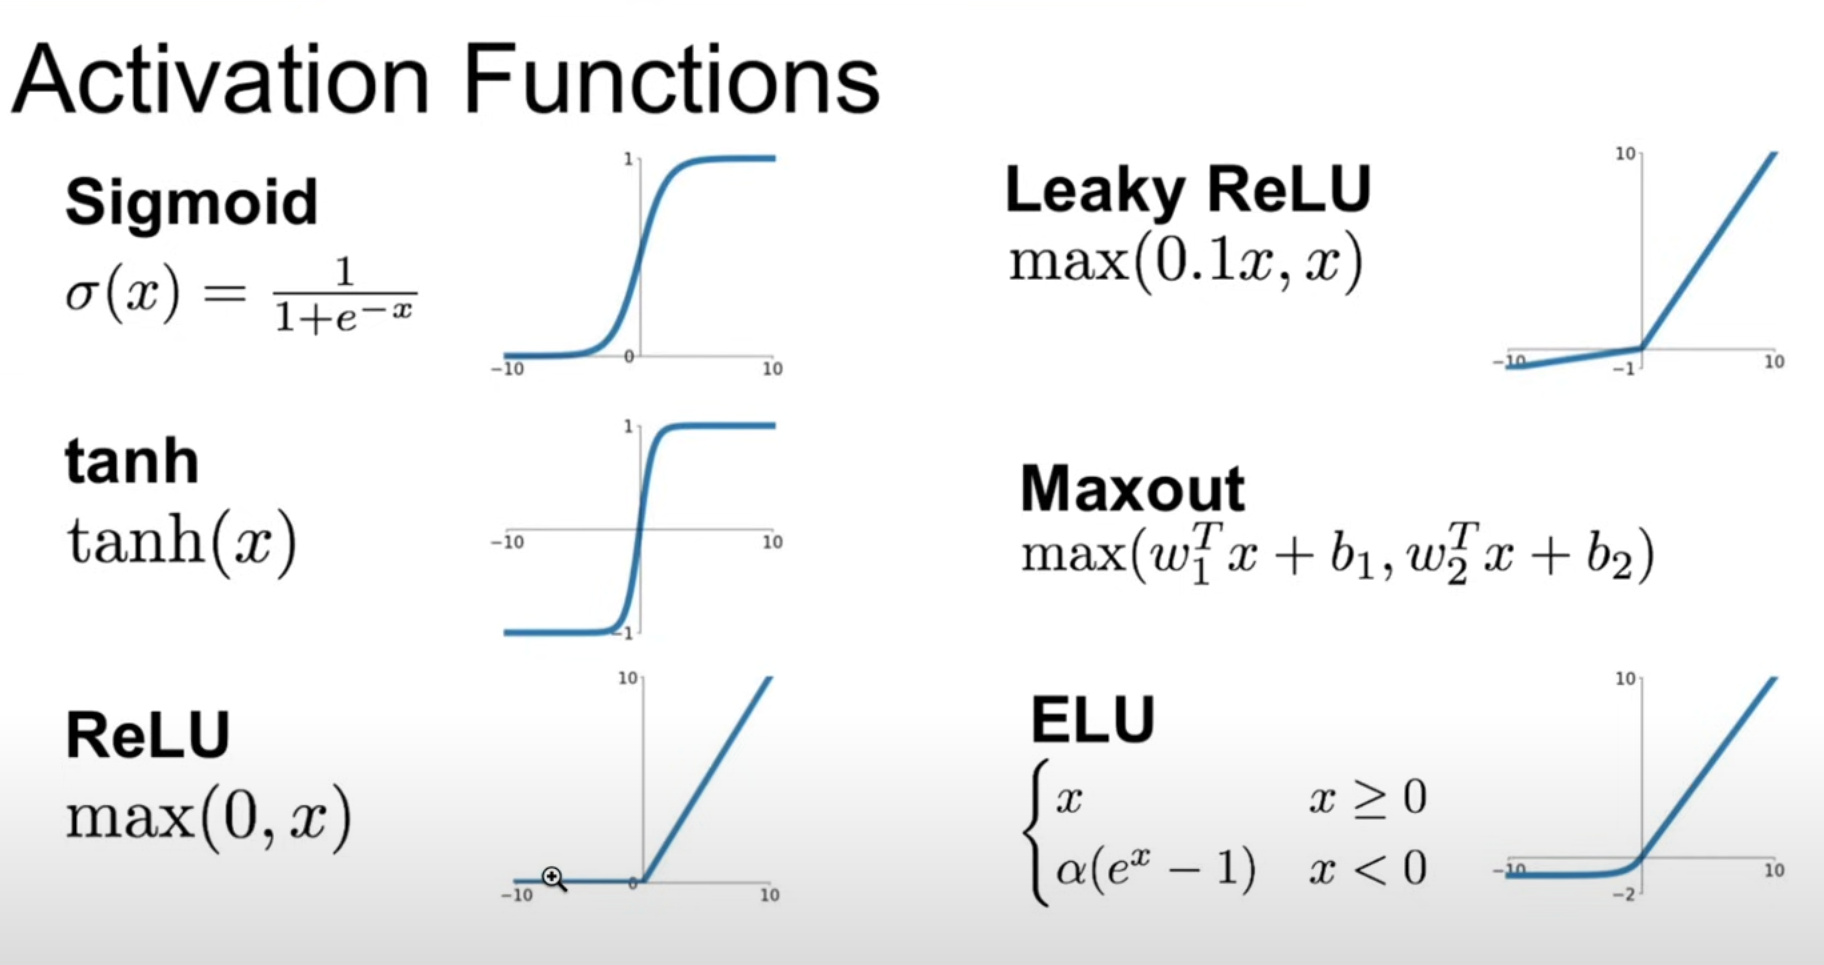

## Output of h - Tanh(preact)

In [ ]:
# stretch h out into one large vector and then convert it into a list
print(h.view(-1).shape)
hList = h.view(-1).tolist()
plt.hist(hList, 50)

torch.Size([6400])


(array([2116.,  146.,   95.,   74.,   50.,   55.,   34.,   29.,   35.,
          23.,   17.,   33.,   26.,   25.,   23.,   13.,   18.,   12.,
          28.,   18.,   26.,   29.,   35.,   12.,   11.,   25.,   11.,
          24.,   17.,   14.,   11.,   40.,   33.,   19.,   17.,   22.,
          35.,   19.,   29.,   40.,   20.,   36.,   33.,   34.,   45.,
          82.,   79.,   99.,  142., 2491.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

## Preaktivation of Tanh
- range is very broad (-15, 15)

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50)

## Problem with Backpropagation Through Tanh Activation

* The **tanh** function is defined as:

  $$
  \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
  $$

* It’s a **non-linear activation function** used to introduce non-linearity in neural networks.

* **Important:** tanh has **no learnable parameters** — it’s a fixed function.

* The main issue during backpropagation:
  When the input $x$ is very large or very small, tanh saturates near +1 or -1, causing its derivative (gradient) to be close to zero.

* This leads to **vanishing gradients**, making it difficult for the network to learn, especially in deep layers.


In [ ]:
# from micrograd
def tanh(self):
    x = self.data
    # t: tanh of x
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      # this is the back propagation
      # good to know d/dx tanh(x) = 1 - tanh^2(x)
      # so (1-tanh^2(x)) is the local derivative
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

## Derivative of tanh and Gradient Behavior

* The local derivative of $\tanh(x)$ is:

  $$
  \frac{d}{dx}\tanh(x) = 1 - \tanh^2(x)
  $$

* What happens when the output $t = \tanh(x)$ is close to the extremes?
  * t = tanh(x)


| $t$ | Derivative $1 - t^2$ |
| -------------- | -------------------- |
| 1              | 0                    |
| -1             | 0                    |
| 0              | 1                    |

* **Implications:**

  * When $\tanh(x)$ saturates near $\pm 1$, the gradient becomes **almost zero**, effectively **killing the gradient**.
  * This causes **vanishing gradients** — weights and biases from previous layers receive almost no updates because their gradients vanish.
  * When $\tanh(x)$ is near zero, the gradient passes through unchanged, allowing learning to continue.

---

**In short:**
If $\tanh(x)$ output is near ±1, gradients vanish; if near 0, gradients flow normally. This saturation causes training difficulties in deep networks.


## Visualizing activation behaviour of Tanh with no gain on W1 - Dead Neurons

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

- every line is one sample
- count_lines = batch_size
- evry column is one neuron (size_hidden_layer)
- white pixel: abs(tanh(x)) > 0.99
- Dead Neuron: all pixel of one neuron (for all sampel inputs) is white
   - means: one column is completely white

## Setting initial W1 and b1 (preactivation of tanh)
- h = tanh(embcat @ W1 + b1)
- W1 = W1 * 0.2 (squashing)
- b1 = b1 * 0.01 (leaving a little bit of entropy)


### Setting factors

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
# embedding matrix: translates discreate input to continuous vectors
C = torch.randn((vocab_size, n_embd),             generator=g)

W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * 0.2  # mutiplying by 0.2 squashes the distribution
b1 = torch.randn(n_hidden,                        generator = g) * 0.01 # multiplying by 0.01 lefts us a 'little' bit of entropy

# make logits very small by scaling them down towards zero
W2 = torch.randn((n_hidden, vocab_size),          generator = g) * 0.01
# we make all biases in b2 zero
b2 = torch.randn(vocab_size,                      generator = g) * 0

parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

In [ ]:
# same optimization as last time
# max_steps = 200000
# max_steps = 200
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construction
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss functino

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every one in a while
    print(f'{i:7d} / {max_steps: 7d}: {loss.item(): .4f}')
  lossi.append(loss.log10().item())
  break

### Preactivation of Tanh

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50)

### Output of Tanh

In [ ]:
hList = h.view(-1).tolist()
plt.hist(hList, 50)

### Neurons activation for all samples of the batch

In [ ]:

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

# Using 'Kaiming init' for initilization - better preactivation for Tanh - Give it some Gain

Paper: [Delving Deep into Rectifiers:
Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852)

## Initial Distribution

In [ ]:
# 1000 examples, 10 dimensional
x = torch.randn(1000, 10)
# weighting layer
# neurons look at 10 inputs, and there are 200 neurons in this hidden layer
w = torch.randn(10,200)
# y: preactivation jof the neurons
y = x @ w

# as gaussian distribution: mean = 0, std = 1
print('x.mean: ',x.mean(), ' x.std: ', x.std())
# after multiplying: mean stays the same, sdt das expanded to 3 -> the gaussian is expanding
print('y.mean: ', y.mean(),' y.std: ', y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density= True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

What we see:
- at initialisation w and x have gaussian like distribution
- after MatMul (x@w) there is no gaussian like distribution

## Distribution for $ w = w * \frac{1}{\sqrt{fan\_in}}$ -> gives Gaussian like behaviour
- fan_in: batch_size
- y = w * b
- y: has std close to gaussian distribution

In [ ]:
# 1000 examples, 10 dimensional
x = torch.randn(1000, 10)
# weighting layer
# neurons look at 10 inputs, and there are 200 neurons in this hidden layer
w = torch.randn(10,200) / 10**0.5
# y: preactivation jof the neurons
y = x @ w

# as gaussian distribution: mean = 0, std = 1
print('x.mean: ', x.mean(),' x.std: ', x.std())
# after multiplying: mean stays the same, sdt das expanded to 3 -> the gaussian is expanding
print('y.mean: ', y.mean(),' y.std: ', y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density= True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

## The right Gain - holding stable distributions over the NN $ w = w * \frac{gain}{\sqrt{fanmode}}$
- [init gain values from pytorch](https://pytorch.org/docs/stable/nn.init.html)
- example gains:
  - tanh(x): $\frac{5}{3}$
  - linear: 1
- why we need gain > 1
  - ReLu and Tanh are contractive transformations
- Karpythy introduces:
  - $w = w * std$
    - std: factor for desired standard deviation
  - $std = \frac{gain}{\sqrt fanmode}$


In [ ]:
#the factor scales the standard deviation
print(torch.randn(10000).std())
print((torch.randn(10000) * 0.2).std())

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
# embedding matrix: translates discreate input to continuous vectors
C = torch.randn((vocab_size, n_embd),             generator=g)

W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3)/((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden,                        generator = g) * 0.01 # multiplying by 0.01 lefts us a 'little' bit of entropy

# make logits very small by scaling them down towards zero
W2 = torch.randn((n_hidden, vocab_size),          generator = g) * 0.01
# we make all biases in b2 zero
b2 = torch.randn(vocab_size,                      generator = g) * 0

parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construction
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss functino

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every one in a while
    print(f'{i:7d} / {max_steps: 7d}: {loss.item(): .4f}')
  lossi.append(loss.log10().item())
  break

# Batch Normalization

Paper: [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
](https://arxiv.org/abs/1502.03167)

example:
- for hpreact = embcat @ W1 + b1
  - hpreact is our batch we want to move

## Formulas we gonna use

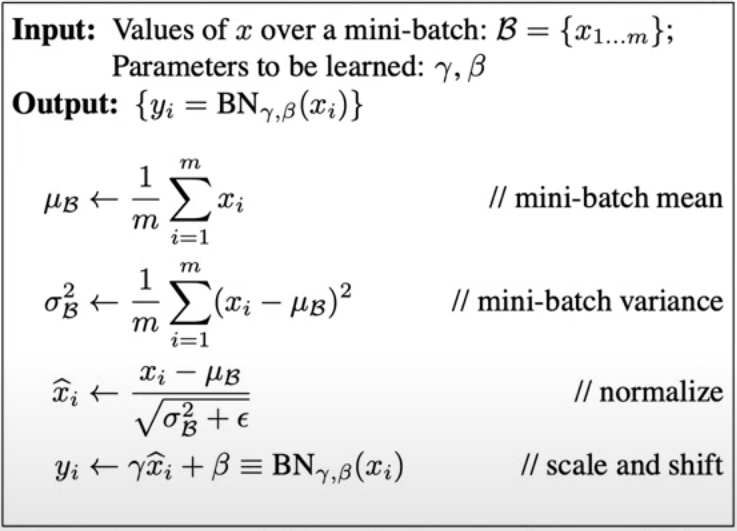

## Implementation - Firat Approach

### Batch Normalization Intuition

* We **normalize the activations** across the batch so that they have:

  * **Zero mean** → centers the data
  * **Unit variance** → standardizes the scale

#### In our case:

* We **don’t use variance** $\sigma^2$ directly — instead, we use **standard deviation** $\sigma$
* The PyTorch code:

```python
hpreact.std(0, keepdim=True)
```

* This computes the **standard deviation for each neuron** across the batch (i.e., over all samples at once).




In [ ]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construction
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # after normalizing every neurons fire rate will be exactly unit Gaussian on the examples of the batch
  # notice: all the used operations are perfectly differentiable
  hpreact = (hpreact - hpreact.mean(0, keepdim = True)) / hpreact.std(0, keepdim = True)
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss functino

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every one in a while
    print(f'{i:7d} / {max_steps: 7d}: {loss.item(): .4f}')
  lossi.append(loss.log10().item())
  break

The Problem with that approach
- we only want the perfect gaussian behaviour at the beginning
- we loose a lot information if every batch gets centered at zero
- also we want the backpropagation to notice different behaviours of different batches

## Using Scale and Shift in BatchNorm

To give the network more flexibility, we add **trainable parameters**:

* `bngain` → initialized to **1**, controls **scaling**
* `bnbias` → initialized to **0**, controls **shifting**

These parameters have the same size as the hidden layer.

---

### What’s Happening:

* After normalization, the input to each neuron is roughly a **standard normal distribution** (mean 0, std 1)
* At the very beginning (first batch), `bngain` and `bnbias` do nothing — so the effect is purely normalization
* **During training**, the network can learn:

  * to **amplify**, **suppress**, or **shift** these normalized activations
  * i.e., it can "move the window" using `bngain` and `bnbias`

This allows the model to benefit from normalization *without losing representational power*.


In [ ]:
# MLP revisited

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),             generator=g)

W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3)/((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden,                        generator = g) * 0.01 # multiplying by 0.01 lefts us a 'little' bit of entropy

W2 = torch.randn((n_hidden, vocab_size),          generator = g) * 0.01
b2 = torch.randn(vocab_size,                      generator = g) * 0

# introducing batch normalization gain
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

In [ ]:
# same optimization as last time
# max_steps = 200000
max_steps = 200
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construction
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # remeber: @ = MatMul, * = elementwise Mul
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # after normalizing every neurons fire rate will be exactly unit Gaussian on the examples of the batch
  # notice: all the used operations are perfectly differentiable
  # bngain: does scaling (initialized by one)
  # bnbias: does off setting (initialized by zero)
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True)) / hpreact.std(0, keepdim = True) + bnbias
  # if you are wondering why this operation works, bngain and bnbias both get broadcasted to size (32,200)
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss functino

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every one in a while
    print(f'{i:7d} / {max_steps: 7d}: {loss.item(): .4f}')
  lossi.append(loss.log10().item())

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x, y = {
      'train' : (Xtr, Ytr),
      'val' : (Xdev, Ydev),
      'test' : ( Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True)) / hpreact.std(0, keepdim = True) + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

## Sampling with batch Normalization

we need to calculate a mean for all training examples at every neuron in the hidden layer

In [ ]:
# calibrate the batch norm at the end of training

# torch.no_grad: is telling pytorch that none of this we are going to call .backward() on
with torch.no_grad():
  #pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  # get preactivatoin for every single training example
  hpreact = embcat @ W1 + b1
  # meassure the mean/ std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

...as bnstd and bnmean now are fixed values, we can input single examples

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x, y = {
      'train' : (Xtr, Ytr),
      'val' : (Xdev, Ydev),
      'test' : ( Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True)) / hpreact.std(0, keepdim = True) + bnbias
  hpreact = bngain * (hpreact - bnmean / bnstd) + bnbias

  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

## The more efficient way to calculate bnmean_running/ bnstd_running for Sampling

In [ ]:
# MLP revisited

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),             generator=g)

W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3)/((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden,                        generator = g) * 0.01 # multiplying by 0.01 lefts us a 'little' bit of entropy

W2 = torch.randn((n_hidden, vocab_size),          generator = g) * 0.01
b2 = torch.randn(vocab_size,                      generator = g) * 0

# introducing batch normalization gain
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# at beginning as we initialize W1 and b1 our h will be roughly gaussian, so mean will be roughly 0 and std will be roughly 1
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

In [ ]:
# same optimization as last time
# max_steps = 200000
max_steps = 400
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construction
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # remeber: @ = MatMul, * = elementwise Mul
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  # after normalizing every neurons fire rate will be exactly unit Gaussian on the examples of the batch
  # notice: all the used operations are perfectly differentiable
  # bngain: does scaling (initialized by one)
  # bnbias: does off setting (initialized by zero)
  bnmeani = hpreact.mean(0, keepdim = True)
  bnstdi = hpreact.std(0, keepdim = True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  # if you are wondering why this operation works, bngain and bnbias both get broadcasted to size (32,200)

  # this operation is on the side of gradient based optimization
  with torch.no_grad():
    bnmean_running = bnmean_running * 0.999 + bnmeani * 0.001
    bnstd_running = bnstd_running * 0.999 + bnstdi * 0.001

  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss functino

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every one in a while
    print(f'{i:7d} / {max_steps: 7d}: {loss.item(): .4f}')
  lossi.append(loss.log10().item())

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x, y = {
      'train' : (Xtr, Ytr),
      'val' : (Xdev, Ydev),
      'test' : ( Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True)) / hpreact.std(0, keepdim = True) + bnbias
  hpreact = bngain * (hpreact - bnmean / bnstd) + bnbias

  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

## Two Key Notes About Batch Normalization

### 1. What is \$\epsilon\$ in

$$
\widehat{x}_i \leftarrow \frac{x_i - \mu_B }{\sqrt{\sigma_B^2 + \epsilon}}
$$

* \$\epsilon\$ is a **small constant**, like `1e-5` or `1e-8`
* Its purpose: **prevent division by zero**

  * If the batch variance \$\sigma\_B^2\$ happens to be zero (e.g. all inputs are identical), this ensures the denominator doesn't break the computation

---

### 2. Why You Can Remove the Bias (`b1`)

* Suppose your hidden layer uses a bias `b1`:

  * You **add** `b1` before batch normalization
  * But then batch norm **subtracts** the batch mean (which includes the effect of `b1`) and adds its own bias (`bnbias`)

* So:
  **`b1` becomes pointless**, because its effect is canceled during normalization
  → Its gradient becomes **zero**, i.e. `b1.grad = 0`

### Conclusion:

* **Don't use a separate bias (`b1`)** when using batch normalization
* Let the **`bnbias` from the BatchNorm layer** act as the bias term instead




## Everything rearranged with notes from Karpathy

We now do not need b1 anymore in way we backpropagate at hpreact as we got bnbias.

In [ ]:
# MLP revisited

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),             generator=g)

W1 = torch.randn((n_embd * block_size, n_hidden), generator = g) * (5/3)/((n_embd * block_size) ** 0.5)
# b1 = torch.randn(n_hidden,                        generator = g) * 0.01 # multiplying by 0.01 lefts us a 'little' bit of entropy

W2 = torch.randn((n_hidden, vocab_size),          generator = g) * 0.01
b2 = torch.randn(vocab_size,                      generator = g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

In [ ]:
# same optimization as last time
# max_steps = 200000
max_steps = 400
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construction
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator = g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 # + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -----------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim = True)
  bnstdi = hpreact.std(0, keepdim = True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = bnmean_running * 0.999 + bnmeani * 0.001
    bnstd_running = bnstd_running * 0.999 + bnstdi * 0.001
  # -----------------------------------------------------------------
  # Non-lenearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss functino

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every one in a while
    print(f'{i:7d} / {max_steps: 7d}: {loss.item(): .4f}')
  lossi.append(loss.log10().item())

# The code rearranged in pytorch style - Get ready for deeper networks
- introducing: Tanh activation distribution, Tanh gradient distribution, Linear Layer - weights gradient distribution, grad/data-ratio

Introducing classes:
  - Linerar
  - BatchNorm1d
  - Tanh

Play with the initial gain and watch the std
- try 5/3, 1, 3, 0.5

## Fokus on Linear Layer + Tanh

In [ ]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g)/ fan_in**0.5 # using /fan_in**0.5 for initilization, later (with torch.no_grad) we also apply * 5/3
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum = 0.1):
    self.eps = eps
    self.momentum = momentum # step size for updating the window of the running variables
    self.training = True
    #parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    #buffers (trained with a runnuing 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    #calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim = True) # batch mean
      xvar = x.var(0, keepdim = True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta # we use .out for visualization later
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
      return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),          generator = g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    # (last layer is like the softmax layer)
    # more correct: this layer gives us the logits vectors0
    Linear(           n_hidden, vocab_size),
    # after the last Lenear Layer F.cross_entropy() gets applied -> Logits + Softmax + ... = Loss
]

with torch.no_grad():
  #last layer: make less confident
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    # boost linear layers by the gain
    if isinstance(layer, Linear):
      layer.weight *= 5/3 #5/3 # 3 # 0.5   #1


# following means: iterate through the layers first, then iterate through the parameters of the layers, note the parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]

print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
   p.requires_grad = True


In [ ]:
# some optimization as last time

# max_steps = 200000
max_steps = 400
batch_size = 32
lossi = []

for i in range(max_steps):

  #minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator = g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  #forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors (batch_size, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph -> this is a pytorch method
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  #track stats
  if i % 10000 == 0: # print every once a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  if i == 10000:
    break

In [ ]:
# visualize histograms

plt.figure(figsize=(20,4)) # width and heigth of the plot
legends= []
# do it for all but the softmax layer
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('t.shape: ', t.shape)
    # print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std()))
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx, = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

In [ ]:
t[0]

## Example with Linear Layers only /The advantage of Tanh()-Layers

### The advantage of Tanh( )- Layers


- a sandwich of linear layers collapses to a single one in it's representation power
- if you were to plot the output as a function of the input you're just getting a linear function
- no matter how many linera layers you stack up you end up with a linear transformation

### Example with Linear Layer only

Play with the Gain:
- 1.0 will work best for Linear Layers

In [ ]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
#layers = [
#  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
#]
layers = [
   Linear(n_embd * block_size, n_hidden), #Tanh(),
   Linear(           n_hidden, n_hidden), #Tanh(),
   Linear(           n_hidden, n_hidden), #Tanh(),
   Linear(           n_hidden, n_hidden), #Tanh(),
   Linear(           n_hidden, n_hidden), #Tanh(),
   Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  # layers[-1].gamma *= 0.1
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #1.0 #5/3 #1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [ ]:
# same optimization as last time
# max_steps = 200000
max_steps = 400
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  #if i >= 1000:
  break # AFTER_DEBUG: would take out obviously to run full optimization

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

## Introducing the Distribution of Weight Gradients



### Play With the Gain Parameter:

**Gain** controls the scale of the inputs into the Tanh activation.
Depending on how large or small it is, it can drastically affect the gradient flow during backpropagation.

---

### High Gain (e.g., `gain = 3.0`):

* Inputs to `tanh` are large → `tanh(x)` outputs are very close to -1 or 1.
* This is called **saturation**.
* **Effect:** The derivative of `tanh(x)` becomes very small (≈ 0).
* **Gradient standard deviation drops** to \~0 → gradients vanish → learning stalls.

---

### Low Gain (e.g., `gain = 0.5`):

* Inputs stay near 0 → `tanh(x)` operates in its linear regime.
* Derivative is relatively large (max = 1).
* **Effect:** Gradients flow more freely, avoiding vanishing issues.

---

###  The Tanh Gradient Behavior

The derivative of tanh is:

$$
\frac{d}{dx}\tanh(x) = 1 - \tanh^2(x)
$$

* If `tanh(x)` ≈ ±1 → derivative ≈ 0 → **vanishing gradient**
* If `tanh(x)` ≈ 0 → derivative ≈ 1 → **good gradient flow**

---

### How We Use Tanh Gradients in PyTorch

* We don’t manually calculate or store Tanh gradients.
* PyTorch’s **autograd** system computes gradients automatically during the **backward pass**.
* In Tanh’s internal logic:

  ```python
  self.out = tanh(x)
  ```

  * `self.out` becomes part of the computation graph.
  * During `backward()`, PyTorch computes:

    $$
    \frac{d \text{Loss}}{d x} = \frac{d \text{Loss}}{d \text{out}} \cdot (1 - \text{out}^2)
    $$



### Example Code

In [ ]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
#layers = [
#  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
#]
layers = [
   Linear(n_embd * block_size, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  # layers[-1].gamma *= 0.1
  # make last layer less confident
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 #1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [ ]:
# same optimization as last time
# max_steps = 200000
max_steps = 400
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if i >= 10000:
  break # AFTER_DEBUG: would take out obviously to run full optimization

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

tanh(x) is calculated for every sample in every neuron
- 32 * 100 per layer

In [ ]:
t.shape


In [ ]:
# visualize histogramm
plt.figure(figsize = (20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the outpue layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    # print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std()))
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx, = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

Now we iterate through the parameters
- we not focus on saturation/ distribution or gradients of the Tanh(x)-layer here, but on there effects
- what we focus on here are the gradients of the weights of the Linear Layers

In [ ]:
# visualize historams
plt.figure(figsize=(20, 4)) # width and height of the plot
legends= []
for i, p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2: # the weights of the 2d layers / skipping biases / skipping gammas and betas
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')


### What We Learn from the Gradient Distribution

#### If a layer's gradients are all close to **zero**:

This means the layer isn't updating much — it’s not **learning effectively**.

**Possible causes:**

* **Saturation** of the activation function (e.g., `tanh(x)` ≈ ±1 → derivative ≈ 0)
* **Poor weight initialization** (e.g., weights too large or too small)
* **Vanishing gradients** through deep layers

---

#### If a layer has **very high gradients**:

These layers:

* Have a **stronger influence** on the model’s predictions
* Learn **faster**, but...
* Can cause **instability** (exploding gradients) if not controlled

---

### Gradient-to-Data Ratio (`grad:data ratio`)

This metric shows how **large the gradient is** compared to the **magnitude of the data itself**.

#### Why it matters:

* If this ratio is **too large**, updates will **overshoot**, causing unstable training.
* If this ratio is **too small**, the layer learns **very slowly** (or not at all).

#### Example of a healthy layer:

```
weight (27, 10) | mean -0.000031 | std 1.365e-03 | grad:data ratio 1.364e-03
```

* Gradients are \~1000× smaller than the actual data → conservative updates → safe learning.

---

### Trouble in the Last Layer

* The **final layer** often has a **much larger gradient-to-data ratio**.
* It sees gradients **10× stronger** than inner layers.
* Standard deviation is **much higher** too.

#### Why is this a problem?

* In **stochastic gradient descent (SGD)**, this means:

  * The **last layer learns \~10× faster** than the rest of the network.
  * Can lead to **imbalance** in training.

---

#### Summary

| Layer | Gradient Size | Data Std | grad\:data ratio | Notes                                   |
| ----- | ------------- | -------- | ---------------- | --------------------------------------- |
| Inner | small         | normal   | ≪ 1              | learning slowly but steadily            |
| Final | large         | higher   | ≫ 1              | learning too quickly, possibly unstable |



# Update-to-Data Ratio: How Aggressive Are Our Updates?





## Formula:

```python
(lr * p.grad.std() / p.data.std()).log10().item()
```

This measures:

> **"How big is the update compared to the current value of the parameter?"**

* `p.grad.std()`: standard deviation of the gradient
* `p.data.std()`: standard deviation of the parameter values
* `lr`: learning rate

A good update/data ratio is typically around `1e-3` (log10 ≈ `-3`)

---

## Playing with Learning Rate

Try:

```python
lr = 0.1      # High, risky
lr = 0.01     # Medium, often works
lr = 0.001    # Safe, but slow
```

The goal:
Find a **learning rate where the model learns steadily**, without exploding gradients or stalling out.

---

## When Things Go Wrong

### Without Proper Initialization (e.g. missing `fan-in` scaling):

```python
# Bad: No scaling
nn.Linear(in_features, out_features)

# Good: Scaled init
nn.Linear(in_features, out_features)
weights *= (1 / sqrt(fan_in))
```

What happens if we skip it?

| Component             | What Goes Wrong                                                      |
| --------------------- | -------------------------------------------------------------------- |
| **Activations**       | Neurons saturate (e.g., tanh(x) → ±1)                                |
| **Gradients**         | Vanish or explode                                                    |
| **Weights**           | Asymmetric or unstable                                               |
| **Update/Data Ratio** | Varies wildly across layers — some learn too fast, others not at all |

---

## What We Want

* Well-calibrated activations (not saturated)
* Consistent gradient flow
* Balanced learning speed across all layers
* Update/data ratio around `1e-3`



In [ ]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) #/ fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
#layers = [
#  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
#]
layers = [
   Linear(n_embd * block_size, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  # layers[-1].gamma *= 0.1
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 #1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [ ]:
# same optimization as last time
# max_steps = 200000
max_steps = 400
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [ ]:
# visualize histogramm
plt.figure(figsize = (20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the outpue layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    # print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std()))
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx, = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

In [ ]:
# visualize historams
plt.figure(figsize=(20, 4)) # width and height of the plot
legends= []
for i, p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2: # the weights of the 2d layers / skipping biases / skipping gammas and betas
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

In [ ]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
# here we are plotting an aproximate value, like an rough guide what the ratio should be
plt.plot([0, len(ud)], [-3,-3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

In [ ]:
len(ud[0])
len(parameters[0])

# Batch Normalization: Why It Makes Training Easier




---

## What’s Different Now?

* **Final layer uses BatchNorm**, not raw weights.
* We don’t initialize weights directly — we initialize:

  * `γ` (gain): starts at 1.0
  * `β` (bias): starts at 0.0

---

## Why?

Without batch norm, we’d need:

* Carefully tuned weight initialization (like multiplying by `5/3`)
* Careful gain control to stabilize activations and gradients

With **BatchNorm**:

* We don’t need special gain scaling (just use `1.0`)
* Activations are **automatically normalized** (zero mean, unit variance)
* That means:

  * **Weights don’t need fan-in scaling**
  * **Gradients behave well**
  * **Update/data ratio is stable**

---

## Observations

* **Gain = 3.0**
  → update/data ratio is stable across all layers
* **Gain = 0.1**
  → update/data ratio in the **input layer** differs heavily from other layers

---

## What if We Skip `fan_in**0.5` Now?

* Weights: random Gaussian
* Activations: still well-behaved
* Gradients: good
* Updates: look okay
* Update/Data ratio: consistent across layers
  → We can **increase learning rate**, e.g. from `0.1` to `1.0`

---

## Summary: BatchNorm Helps By...

| Benefit                          | Explanation                                 |
| -------------------------------- | ------------------------------------------- |
| No special gain init          | The input to each layer is standardized     |
| Less sensitive to weight init | Even bad weight scales won’t break training |
| No need for Kaiming init      | Many practitioners skip it with BatchNorm   |
| Just tune the learning rate   | Main thing left to calibrate                |

---

## Caution

* **Too high learning rate?**
  → Training will **explode**
* **Too low learning rate?**
  → Model will **crawl**


In [ ]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) #/fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #0.1 #5/3 # 1.0  #1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [ ]:
# same optimization as last time
# max_steps = 200000
max_steps = 400
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 1 if i < 150000 else 0.1 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  #if i >= 1000:
  #  break # AFTER_DEBUG: would take out obviously to run full optimization

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [ ]:
# visualize histogramm
plt.figure(figsize = (20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the outpue layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    # print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std()))
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx, = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

In [ ]:
# visualize historams
plt.figure(figsize=(20, 4)) # width and height of the plot
legends= []
for i, p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2: # the weights of the 2d layers / skipping biases / skipping gammas and betas
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

In [ ]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
# here we are plotting an aproximate value, like an rough guide what the ratio should be
plt.plot([0, len(ud)], [-3,-3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

## Testing / Sampling

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

In [ ]:

# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

# Extra Stuff from Karpathy

## See Batch Normalization working

We start with an initial tensor containing 5 values, one of which can be modified using a slider. The blue line represents the normal distribution calculated from the original data (X), using its own mean and standard deviation.

The red line shows a standard normal distribution (mean = 0, standard deviation = 1), and the red dots represent the standardized values of X after applying z-score normalization.

In [ ]:
# BatchNorm forward pass as a widget

# use interact for interactive methods
# pdf: probability desity function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):

  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig # GPT sagt: wird auf std 1 transformiert

  plt.figure(figsize=(10, 5)) # opens new matplot figure
  ## plot 0
  plt.plot([-6,6], [0,0], 'k') # plots a line at x=0, from -6 to 6
  ## plot the mean and std
  xx = np.linspace(-6, 6, 100) # creates array with 100 even distributet values from -6 to 6
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b') # normal distribution
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r') #
  ## plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  ## plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  ## title
  plt.title('input mu %.2f std %.2f' % (mu, sig))
  print('x: ', x.sort(), '\n mean: ', mu, '\n std: ', sig)
  print('y: ', y.sort())

# creates slider with values form -30 to 30 in steps of 0.5
interact(normshow, x0=(-30,30,0.5));

What we see in the following example:

- Gradient explosion can happen even in very simple linear layers.

- There should be a healthy ratio between the values and their gradients.

- If gradients are too large or too small compared to the activations, we learn either too fast or too slow.

- Techniques like careful weight initialization or batch normalization can help prevent these issues.



In [ ]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a

loss = torch.randn(1000, generator=g) @ c

#a.retain_grad()
b.retain_grad()
c.retain_grad()

loss.backward()

print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())
print('c grad std:', c.grad.std().item())


Small example of 'Kaiming' (/n**0.5) vs. 'Batch Normalization'

In [ ]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000

# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp

# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)

# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())